## Run Regressions on Generated Factors

## Load Processed Data

In [24]:
import pandas as pd 
from utils import *
import os

# load data
DATA_DIR = os.path.abspath("../../data/processed")

sage_factors = pd.read_csv(os.path.join(DATA_DIR, "sage_factors.csv"))
uniqueness = pd.read_csv(os.path.join(DATA_DIR, "uniqueness.csv"))
mod_ind_momentum = pd.read_csv(os.path.join(DATA_DIR, "mod_ind_momentum.csv"))

## Merge Data

In [25]:
# standardize date columns
sage_factors["MONTH_END"] = pd.to_datetime(sage_factors["MONTH_END"]) + pd.offsets.MonthEnd(0)
uniqueness["MONTH_END"] = pd.to_datetime(uniqueness["MONTH_END"]) + pd.offsets.MonthEnd(0)
mod_ind_momentum["MONTH_END"] = pd.to_datetime(mod_ind_momentum["MONTH_END"]) + pd.offsets.MonthEnd(0)

# merge data
data = pd.merge(sage_factors, uniqueness, on=["COMPANY_ID", "MONTH_END"], how="left").reset_index(drop=True)
data = pd.merge(data, mod_ind_momentum, on=["COMPANY_ID", "MONTH_END"], how="left").reset_index(drop=True)

# get column names for each momentum window combination 
window_sizes = [3, 6, 12, 24, 48]
momentum_columns = [f'avg_modality_momentum_{window}m' for window in window_sizes] + [f'avg_indication_momentum_{window}m' for window in window_sizes]

data = data.dropna(subset=["uniqueness"] + momentum_columns)
data.columns = [col.lower() for col in data.columns]

In [28]:
print(data.shape)
print(data.head(10).to_markdown(index=False))
assert(data.shape == (101601, 27))

(101601, 27)
| month_end           |   company_id |   excess_return_usd_ln |   excess_return_usd |   quality |     value |   coverage |    momentum |      size |   earnings_volatility |      growth |   trading_activity |   leverage |   volatility | reg_group   |   uniqueness |   price_close_usd |   avg_modality_momentum_3m |   avg_modality_momentum_6m |   avg_modality_momentum_12m |   avg_modality_momentum_24m |   avg_modality_momentum_48m |   avg_indication_momentum_3m |   avg_indication_momentum_6m |   avg_indication_momentum_12m |   avg_indication_momentum_24m |   avg_indication_momentum_48m |
|:--------------------|-------------:|-----------------------:|--------------------:|----------:|----------:|-----------:|------------:|----------:|----------------------:|------------:|-------------------:|-----------:|-------------:|:------------|-------------:|------------------:|---------------------------:|---------------------------:|----------------------------:|------------------------

## Restrict Historical Date Range

In [30]:
# data = data[data["month_end"] >= "2010-01-01"]

## Define Factors

In [54]:
# sage factors
financial_factors = ['quality', 'value', 'coverage', 'momentum', 'size',
    'earnings_volatility', 'growth', 'trading_activity', 'leverage',
    'volatility'
]

uniqueness_factor = ['uniqueness']

# modality and indication momentum factors
window_sizes = [12]
mod_ind_momentum_factors = [f'avg_modality_momentum_{window}m' for window in window_sizes] + [f'avg_indication_momentum_{window}m' for window in window_sizes]
print(mod_ind_momentum_factors)

# Load the modalities and indications from the resources folder.
RESOURCES_DIR = os.path.abspath("../../resources")
with open(os.path.join(RESOURCES_DIR, "modaliities.txt"), "r") as f:
    modalities = [line.strip().upper() for line in f]
with open(os.path.join(RESOURCES_DIR, "indications.txt"), "r") as f:
    indications = [line.strip().upper() for line in f]

# raw modalities and indications
mod_ind_factors = [mi.lower() for mi in modalities + indications]

['avg_modality_momentum_12m', 'avg_indication_momentum_12m']


## Z-score Data

In [55]:
#id variable are used to connect results back to other data
id_variables = ['month_end', 'company_id']

dependent_variable = 'excess_return_usd_ln'
independent_variables = financial_factors + uniqueness_factor + mod_ind_momentum_factors

#the monthly regression function will create dummy variables from a column but you must specify which dummy value to drop
dummy_variables = []
dummy_drop_dict = {
}

#re z-score the data and set NAs to 0
z_scored_data = z_score_by_date(data, independent_variables, 'month_end', suffix = '_z', clip=3, fillna_zero = True)

## Run Regression

In [77]:
regression_stats, coefficients, coefficients_pivot, regression_fitted = run_monthly_regression(
    z_scored_data, 
    id_variables, 
    dependent_variable, 
    independent_variables, 
    dummy_variables, 
    dummy_drop_dict
)

## Show Sumamry Regression Stats and Historical R2

| statistic   |   r_squared |      y_mean |   y_stdev |      rmse |     y_mad |      mae |   std_improvement |   mad_improvement |
|:------------|------------:|------------:|----------:|----------:|----------:|---------:|------------------:|------------------:|
| mean        |   0.129589  | -0.0136059  | 0.192067  | 0.187215  | 0.13179   | 0.124269 |        0.004852   |        0.00752081 |
| median      |   0.114962  | -0.00605093 | 0.184311  | 0.181306  | 0.126008  | 0.120185 |        0.00300528 |        0.00582331 |
| stdev       |   0.0687618 |  0.0896419  | 0.0410398 | 0.0387401 | 0.0278492 | 0.024477 |        0.0022997  |        0.00337222 |


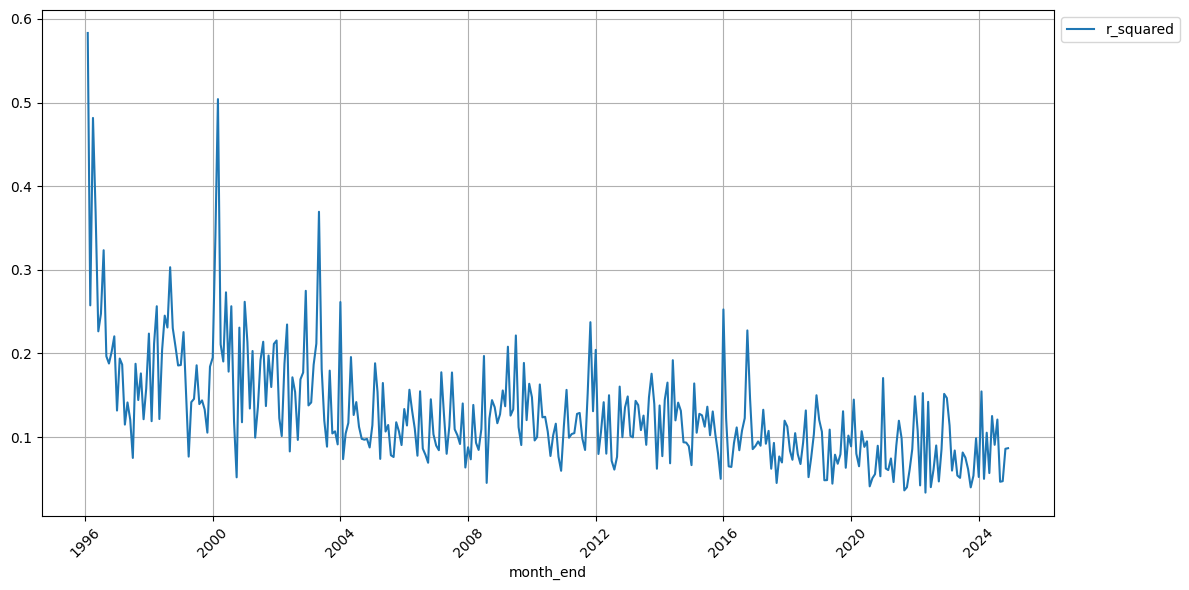

In [78]:
#calc summary stats gives us 
print(calc_summary_regression_stats(regression_stats).head().to_markdown(index=False))
#regression_stats = regression_stats.sort_values(by='month_end')
time_series_df_plot(regression_stats, 'month_end', ['r_squared'])

## Show Summary for Coefficients

In [79]:
summary = calc_summary_coefficients(coefficients, sort_order = independent_variables)
# summary["variable"] = summary["variable"].str[:20]
print(summary.to_markdown(index=False))

| variable                    |   avg_ceoff |     stdev |     Sharpe |   avg_p_value |   perc_below_0.05 |
|:----------------------------|------------:|----------:|-----------:|--------------:|------------------:|
| const                       | -0.0378728  | 0.244434  | 0.154941   |      0.421658 |         0.112392  |
| quality                     |  0.0065387  | 0.0187408 | 0.348902   |      0.456258 |         0.0634006 |
| value                       |  0.00842699 | 0.0209059 | 0.403091   |      0.432726 |         0.112392  |
| coverage                    |  0.00404865 | 0.0182025 | 0.222422   |      0.475715 |         0.0605187 |
| momentum                    |  0.00338831 | 0.0199992 | 0.169422   |      0.420091 |         0.161383  |
| size                        |  0.00421991 | 0.021658  | 0.194843   |      0.384066 |         0.149856  |
| earnings_volatility         | -0.00108607 | 0.0167498 | 0.0648409  |      0.45018  |         0.0835735 |
| growth                      | -0.00

## Graph Cumulative Coefficients

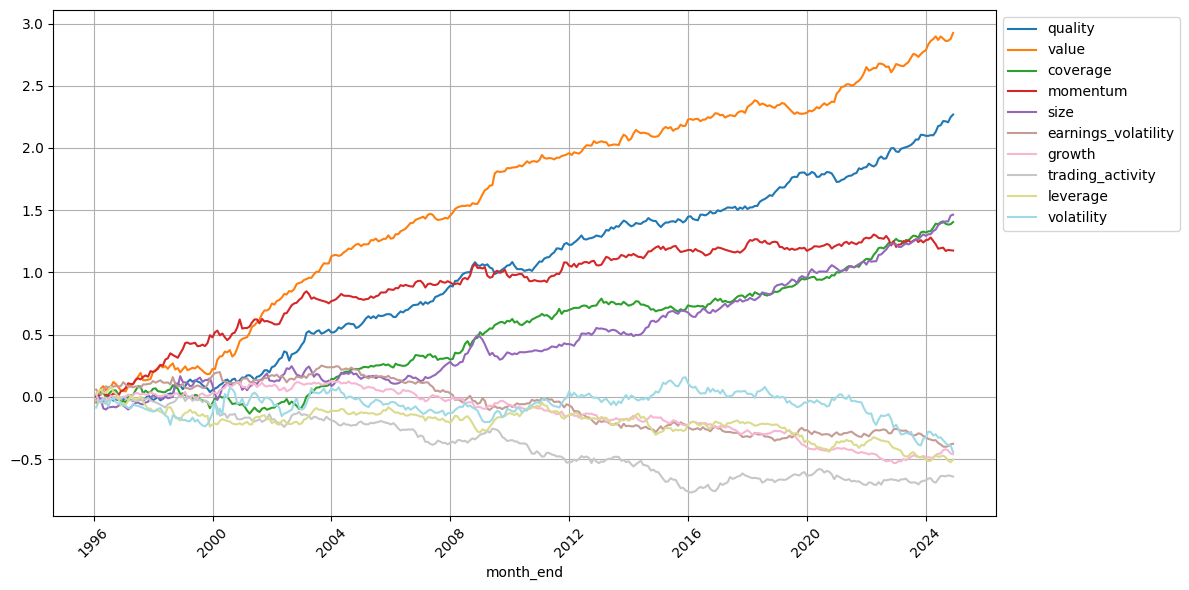

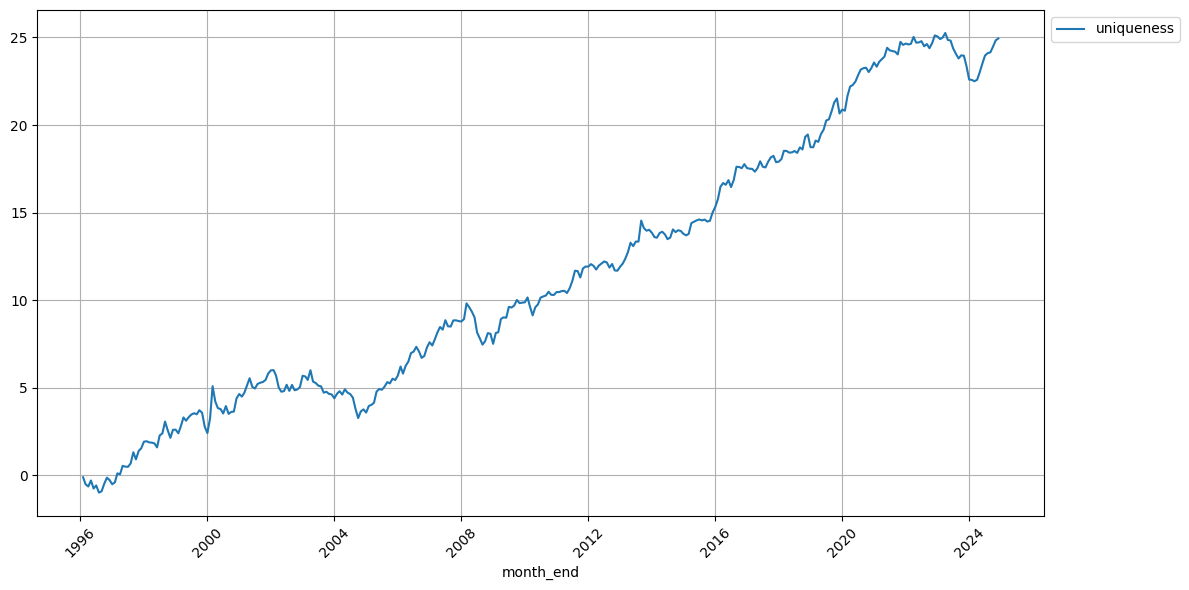

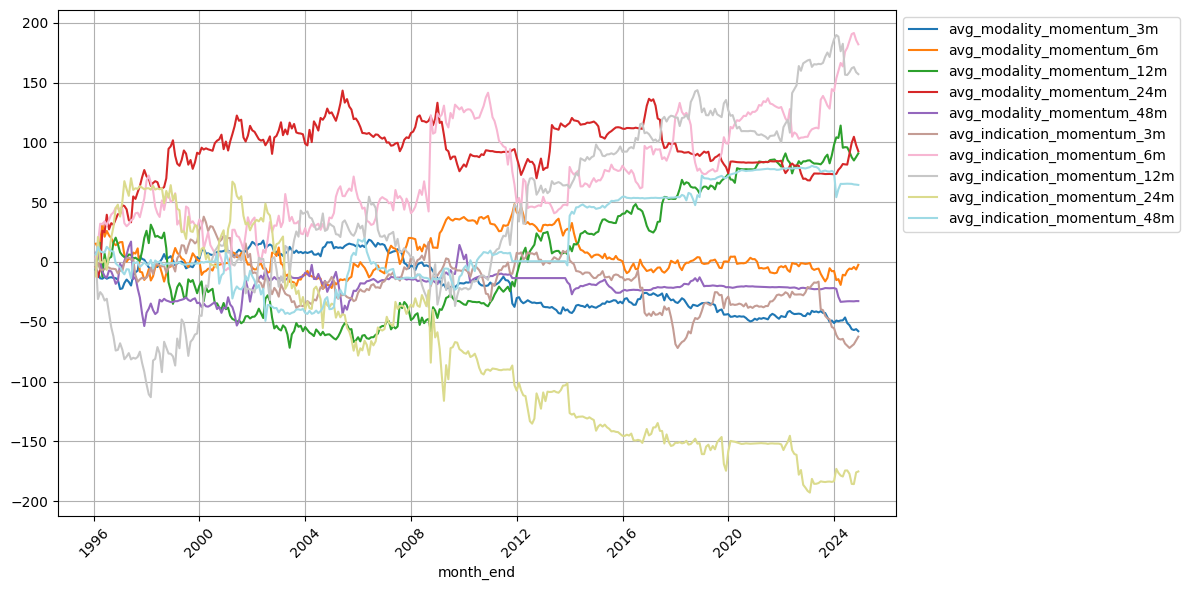

In [80]:
cumulative_ceoff = calculate_cumulative_coefficients(coefficients_pivot, 'month_end')
time_series_df_plot(cumulative_ceoff, 'month_end', financial_factors)
time_series_df_plot(cumulative_ceoff, 'month_end', ["uniqueness"])
time_series_df_plot(cumulative_ceoff, 'month_end', mod_ind_momentum_factors)

## Define Factors for All Window Sizes

In [81]:
# sage factors
financial_factors = ['quality', 'value', 'coverage', 'momentum', 'size',
    'earnings_volatility', 'growth', 'trading_activity', 'leverage',
    'volatility'
]

uniqueness_factor = ['uniqueness']

# modality and indication momentum factors
window_sizes = [3, 6, 12, 24, 48]
mod_ind_momentum_factors = [f'avg_modality_momentum_{window}m' for window in window_sizes] + [f'avg_indication_momentum_{window}m' for window in window_sizes]

# Load the modalities and indications from the resources folder.
RESOURCES_DIR = os.path.abspath("../../resources")
with open(os.path.join(RESOURCES_DIR, "modaliities.txt"), "r") as f:
    modalities = [line.strip().upper() for line in f]
with open(os.path.join(RESOURCES_DIR, "indications.txt"), "r") as f:
    indications = [line.strip().upper() for line in f]

# raw modalities and indications
mod_ind_factors = [mi.lower() for mi in modalities + indications]

## Z-score Data for All Window Sizes

In [82]:
#id variable are used to connect results back to other data
id_variables = ['month_end', 'company_id']

dependent_variable = 'excess_return_usd_ln'
independent_variables = financial_factors + uniqueness_factor + mod_ind_momentum_factors

#the monthly regression function will create dummy variables from a column but you must specify which dummy value to drop
dummy_variables = []
dummy_drop_dict = {
}

#re z-score the data and set NAs to 0
z_scored_data = z_score_by_date(data, independent_variables, 'month_end', suffix = '_z', clip=3, fillna_zero = True)

## Run Regression for All Window Sizes

In [83]:
regression_stats, coefficients, coefficients_pivot, regression_fitted = run_monthly_regression(
    z_scored_data, 
    id_variables, 
    dependent_variable, 
    independent_variables, 
    dummy_variables, 
    dummy_drop_dict
)

## Graph Cumulative Coefficients for All Window Sizes

| statistic   |   r_squared |      y_mean |   y_stdev |      rmse |     y_mad |      mae |   std_improvement |   mad_improvement |
|:------------|------------:|------------:|----------:|----------:|----------:|---------:|------------------:|------------------:|
| mean        |   0.129589  | -0.0136059  | 0.192067  | 0.187215  | 0.13179   | 0.124269 |        0.004852   |        0.00752081 |
| median      |   0.114962  | -0.00605093 | 0.184311  | 0.181306  | 0.126008  | 0.120185 |        0.00300528 |        0.00582331 |
| stdev       |   0.0687618 |  0.0896419  | 0.0410398 | 0.0387401 | 0.0278492 | 0.024477 |        0.0022997  |        0.00337222 |


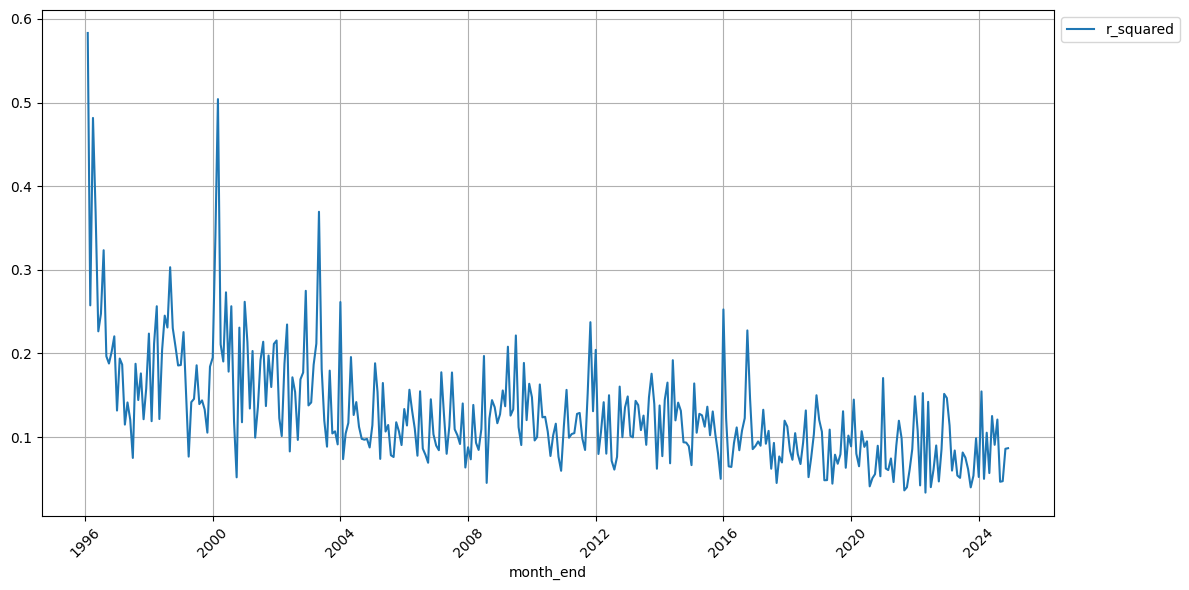

In [84]:
#calc summary stats gives us 
print(calc_summary_regression_stats(regression_stats).head().to_markdown(index=False))
#regression_stats = regression_stats.sort_values(by='month_end')
time_series_df_plot(regression_stats, 'month_end', ['r_squared'])

## Show Sumamry Regression Stats and Historical R2 for All Window Sizes

In [85]:
summary = calc_summary_coefficients(coefficients, sort_order = independent_variables)
# summary["variable"] = summary["variable"].str[:20]
print(summary.to_markdown(index=False))

| variable                    |   avg_ceoff |     stdev |     Sharpe |   avg_p_value |   perc_below_0.05 |
|:----------------------------|------------:|----------:|-----------:|--------------:|------------------:|
| const                       | -0.0378728  | 0.244434  | 0.154941   |      0.421658 |         0.112392  |
| quality                     |  0.0065387  | 0.0187408 | 0.348902   |      0.456258 |         0.0634006 |
| value                       |  0.00842699 | 0.0209059 | 0.403091   |      0.432726 |         0.112392  |
| coverage                    |  0.00404865 | 0.0182025 | 0.222422   |      0.475715 |         0.0605187 |
| momentum                    |  0.00338831 | 0.0199992 | 0.169422   |      0.420091 |         0.161383  |
| size                        |  0.00421991 | 0.021658  | 0.194843   |      0.384066 |         0.149856  |
| earnings_volatility         | -0.00108607 | 0.0167498 | 0.0648409  |      0.45018  |         0.0835735 |
| growth                      | -0.00

## Graph Cumulative Coefficients for All Window Sizes

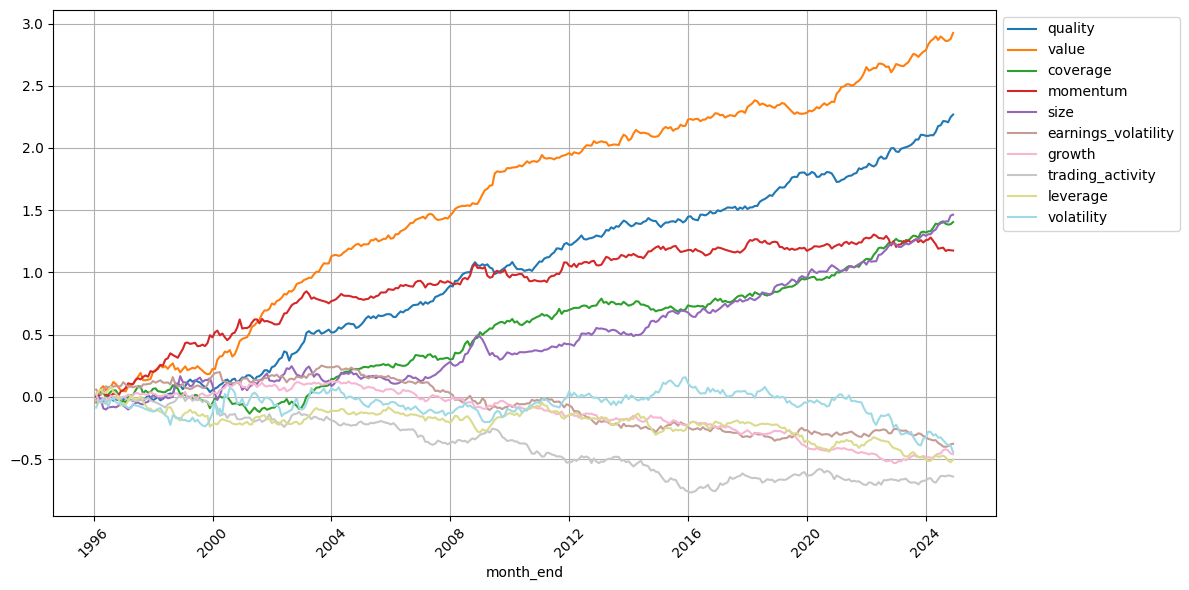

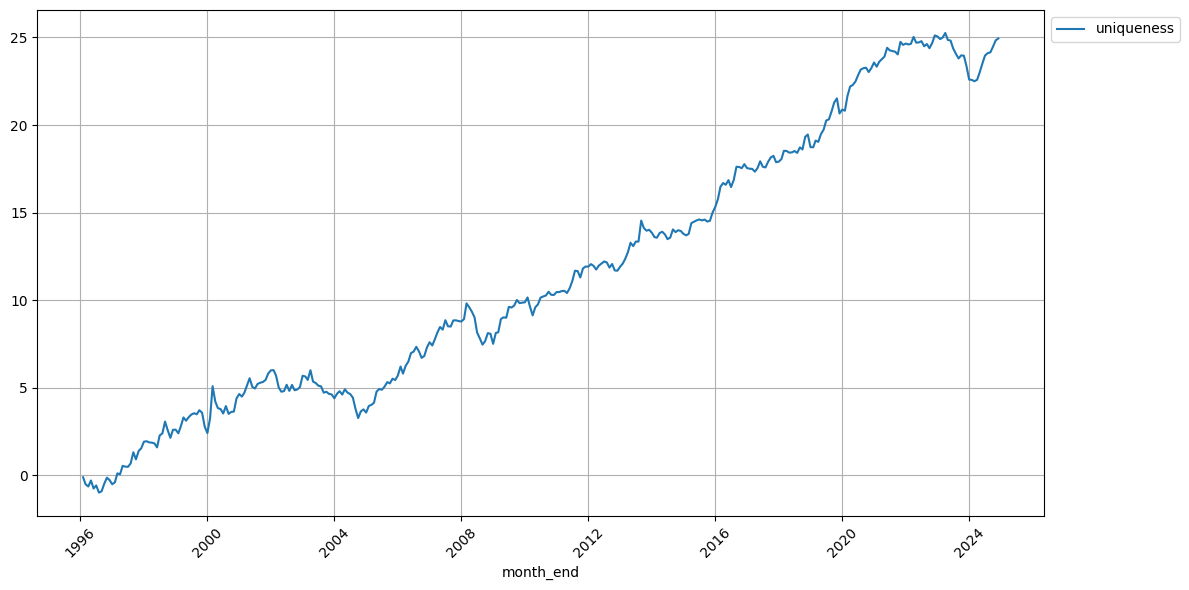

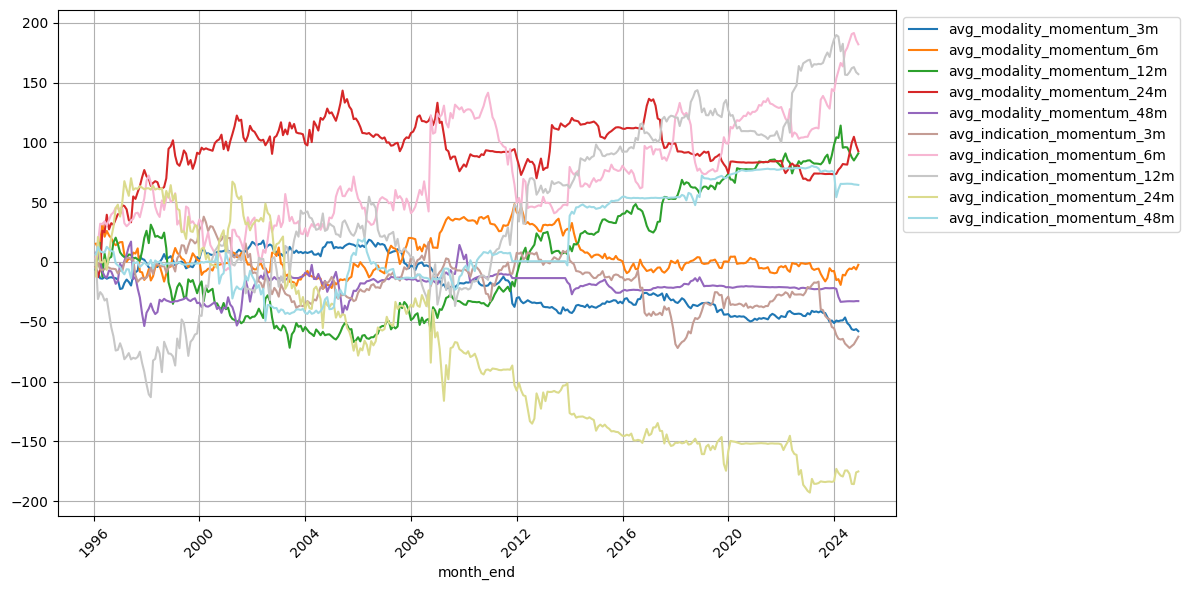

In [86]:
cumulative_ceoff = calculate_cumulative_coefficients(coefficients_pivot, 'month_end')
time_series_df_plot(cumulative_ceoff, 'month_end', financial_factors)
time_series_df_plot(cumulative_ceoff, 'month_end', ["uniqueness"])
time_series_df_plot(cumulative_ceoff, 'month_end', mod_ind_momentum_factors)